# Getting POI Data

In [3]:
#Importing the important libraries
import pandas as pd
import geopandas as gp
# OSMNX for getting OpenStreetMap Data
import osmnx as ox
# Folium for plotting maps
import folium

In [4]:
# Import POIs with an amenity tag
# https://wiki.openstreetmap.org/wiki/Key:amenity
tags = {'amenity': True}
poi = ox.geometries_from_place(query = {'city': 'Chicago'}, tags=tags)

# As we will see later not all public transport stops are marked with an amenity tag
# Therefore we will load a second datasetfor public transport related POIs
# https://wiki.openstreetmap.org/wiki/Key:public_transport
tags = {'public_transport': True}
transport = ox.geometries_from_place(query = {'city': 'Chicago'}, tags=tags)

### Amenity Data

In [5]:
# As we loaded the public transport data as a second dataframe we now exclude the double entries
poi = poi[poi["public_transport"].isna()]

In [6]:
# Reduce dataframe to important columns
poiDF = poi[["amenity", "geometry", "name"]].reset_index().set_index("osmid").drop("element_type", axis = 1).copy()
poiDF.tail(3)

,amenity,geometry,name
osmid,,,
15907961,parking,"MULTIPOLYGON (((-87.88232 41.98844, -87.88258 ...",Contractor Lot J
15910908,shelter,"POLYGON ((-87.62616 41.87921, -87.62615 41.878...",NaN
15925258,theatre,"POLYGON ((-87.62925 41.88838, -87.62908 41.888...",House of Blues


In [7]:
# Have a look at the different types of POI and their occurrence
print(poiDF.groupby("amenity").count()["geometry"].sort_values(ascending=False).to_string())

amenity
parking                    6529
restaurant                 2199
place_of_worship           1881
fast_food                  1263
school                     1227
bar                         855
bicycle_parking             835
bicycle_rental              815
cafe                        745
bench                       736
bank                        448
fuel                        418
parking_entrance            266
post_box                    229
toilets                     222
shelter                     219
fountain                    209
social_facility             193
pharmacy                    181
drinking_water              178
loading_dock                160
clinic                      140
waste_basket                125
library                     109
fire_station                103
post_office                 100
pub                         100
ice_cream                   100
atm                          96
vending_machine              92
studio                       92


In [8]:
# For later analyses it could be interesting to group some tags and make a simpler categorization
# We don't group some items like for example transport related tags as their differences could be of importance
# Parking & Transport related POIs
car_parking = ["parking", "parking_entrance", 'parking_space']
bicycle_parking = ["bicycle_parking"]
bicycle_rental = ["bicycle_rental"]
bicycle_repair_station  =  ['bicycle_repair_station']
taxi = ['taxi']
car_sharing = ['car_sharing']
car_rental = ['car_rental']
water_transport = ["water_transport",'loading_dock', 'boat_rental','boat_storage']
fuel = ["fuel"]
# Other maybe important POIs
gastronomy = ["gastronomy", 'fast_food', 'cafe', 'restaurant', 'pub', 'bar', 'ice_cream', 'food_court', 'fast_food;ice_cream', 'biergarten']
place_of_worship = ['place_of_worship']
finance = ["finance", 'bank', 'atm', 'bureau_de_change', 'money_transfer', 'payment_terminal', 'payment_centre']
sports = ["sports", 'pilates', 'training']
health = ["health", 'pharmacy', 'hospital', 'dentist', 'clinic', 'nursing_home', 'doctors']
education = ["education", "music_school", 'school', 'university', 'college', 'language_school', 'library', 'prep_school', 'flight_school','research_institute']
nightlife = ["nightlife", 'stripclub', 'nightclub']
culture = ["culture", 'theatre', 'cinema', 'events_venue', 'planetarium', 'music_venue', 'arts_centre', 'exhibition_centre']
children = ["children", 'childcare', "kindergarten"]
police = ["police"]

category_list = [
car_parking,
bicycle_parking,
bicycle_rental,
bicycle_repair_station,
taxi,
car_sharing,
car_rental,
water_transport,
fuel,
gastronomy,
place_of_worship,
finance,
sports,
health,
education,
nightlife,
culture,
children,
police]

In [9]:
# Method to apply our categorization to a row of the dataframe
def simpleCategory(row):
    for x in category_list:
        if row["amenity"] in x:
            return x[0]
    return "other"

In [10]:
# Create a column with our categorization
poiDF["category"] = poiDF.apply(simpleCategory, axis=1)

In [11]:
# Have a look at the resulting occurences of categories
print(poiDF.groupby("category").count()["geometry"].sort_values(ascending=False).to_string())

category
parking                   6841
gastronomy                5281
other                     2952
place_of_worship          1881
education                 1437
bicycle_parking            835
bicycle_rental             815
finance                    590
health                     486
fuel                       418
culture                    177
water_transport            166
children                    52
police                      38
nightlife                   24
car_rental                  24
bicycle_repair_station      19
taxi                        10
car_sharing                  2
sports                       2


In [12]:
poiDF.tail(3)

,amenity,geometry,name,category
osmid,,,,
15907961,parking,"MULTIPOLYGON (((-87.88232 41.98844, -87.88258 ...",Contractor Lot J,parking
15910908,shelter,"POLYGON ((-87.62616 41.87921, -87.62615 41.878...",NaN,other
15925258,theatre,"POLYGON ((-87.62925 41.88838, -87.62908 41.888...",House of Blues,culture


In [13]:
# Method that returns a tuple containing the Latitude and longitude
#def getLatLong(row):
    #if (row.geometry.geom_type == "Point"):
        #return tuple([row.geometry.x, row.geometry.y])
    # For all POIs that are not only points, but polygons or multigons we return the center coordinates
    #else:
        #return tuple([row.geometry.centroid.x, row.geometry.centroid.y])

In [14]:
# Add column with latitude, longitude tuple
#poiDF["lat_long"] = poiDF.apply(getLatLong, axis=1)

In [15]:
# Method that returns the Latitude and longitude
def getLatAndLong(row):
    if (row.geometry.geom_type == "Point"):
        return [row.geometry.y, row.geometry.x]
    # For all POIs that are not only points, but polygons or multigons we return the center coordinates
    else:
        return [row.geometry.centroid.y, row.geometry.centroid.x]

In [16]:
# Add columns with latitude and longitude
poiDF[["latitude", "longitude"]] = poiDF.apply(getLatAndLong, axis=1, result_type='expand')

In [17]:
poiDF.tail(3)

,amenity,geometry,name,category,latitude,longitude
osmid,,,,,,
15907961,parking,"MULTIPOLYGON (((-87.88232 41.98844, -87.88258 ...",Contractor Lot J,parking,41.988025,-87.881296
15910908,shelter,"POLYGON ((-87.62616 41.87921, -87.62615 41.878...",NaN,other,41.879540,-87.626137
15925258,theatre,"POLYGON ((-87.62925 41.88838, -87.62908 41.888...",House of Blues,culture,41.888259,-87.629116


### Public Transport Data

In [18]:
# Reduce dataframe to important columns
transportDF = transport[["public_transport", "wheelchair", "geometry", "name", "amenity"]].reset_index().set_index("osmid").drop("element_type", axis = 1)

In [19]:
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity
osmid,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal
20217442,stop_position,NaN,POINT (-87.63774 41.87906),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal


In [20]:
# Look at different type of "public_transport" tags
print(transportDF.groupby("public_transport").count()["geometry"].sort_values(ascending=False).to_string())

public_transport
platform          10662
stop_position      5520
station             261
no                   19
service_center        3


In [21]:
# https://wiki.openstreetmap.org/wiki/Key:public_transport
# Only keep relevant entries
transportDF = transportDF[transportDF["public_transport"].isin(["platform", "stop_position", "station"])].copy()

In [22]:
# Add column with latitude, longitude tuple
#transportDF["lat_long"] = transportDF.apply(getLatLong, axis=1)

In [23]:
# Add columns with latitude and longitude
transportDF[["latitude", "longitude"]] = transportDF.apply(getLatAndLong, axis=1, result_type='expand')

In [24]:
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity,latitude,longitude
osmid,,,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal,41.889146,-87.622517
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal,41.887824,-87.631768
20217442,stop_position,NaN,POINT (-87.63774 41.87906),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal,41.879062,-87.637740


### Merging the two dataframes

In [25]:
transportDF["category"] = "public_transport"
transportDF.head(3)

,public_transport,wheelchair,geometry,name,amenity,latitude,longitude,category
osmid,,,,,,,,
20217109,station,NaN,POINT (-87.62252 41.88915),Michigan Avenue Bridge Dock,ferry_terminal,41.889146,-87.622517,public_transport
20217237,stop_position,NaN,POINT (-87.63177 41.88782),River North Water Taxi Terminal,ferry_terminal,41.887824,-87.631768,public_transport
20217442,stop_position,NaN,POINT (-87.63774 41.87906),Willis Tower/Union Station Water Taxi Terminal,ferry_terminal,41.879062,-87.637740,public_transport


In [26]:
df = pd.concat([poiDF, transportDF], axis = 0, join = "outer")
df

,amenity,geometry,name,category,latitude,longitude,public_transport,wheelchair
osmid,,,,,,,,
258490031,parking,POINT (-87.64385 41.95123),NaN,parking,41.951227,-87.643847,NaN,NaN
269449042,parking_entrance,POINT (-87.61506 41.85869),NaN,parking,41.858689,-87.615058,NaN,NaN
269450074,parking_entrance,POINT (-87.58421 41.79174),NaN,parking,41.791742,-87.584208,NaN,NaN
269688947,post_box,POINT (-87.77220 42.00407),NaN,other,42.004073,-87.772198,NaN,NaN
270863340,parking_entrance,POINT (-87.61564 41.86421),NaN,parking,41.864208,-87.615638,NaN,NaN
...,...,...,...,...,...,...,...,...
13621412,NaN,"POLYGON ((-87.66859 41.91735, -87.66895 41.917...",NaN,public_transport,41.917203,-87.668448,platform,NaN
13621413,NaN,"POLYGON ((-87.66793 41.91671, -87.66797 41.916...",NaN,public_transport,41.917215,-87.668182,platform,NaN
13621414,NaN,"POLYGON ((-87.66801 41.91728, -87.66800 41.917...",NaN,public_transport,41.917277,-87.668066,platform,NaN


In [27]:
print(df.groupby("category").count()["geometry"].sort_values(ascending=False).to_string())

category
public_transport          16443
parking                    6841
gastronomy                 5281
other                      2952
place_of_worship           1881
education                  1437
bicycle_parking             835
bicycle_rental              815
finance                     590
health                      486
fuel                        418
culture                     177
water_transport             166
children                     52
police                       38
nightlife                    24
car_rental                   24
bicycle_repair_station       19
taxi                         10
car_sharing                   2
sports                        2


### Saving dataframe

In [28]:
df.to_pickle("data/poi/poi.pickle")

## Testwise Plotting

In [29]:
df = pd.read_pickle("data/poi/poi.pickle")

In [30]:
places = ["pub", "cafe", "restaurant"]
testDF = df[df["amenity"].isin(places)]
testDF = testDF.head(100)

In [31]:
m = folium.Map([41.88065, -87.62642], zoom_start=10)

for index, row in testDF.iterrows():
    if row["amenity"] == "cafe":
        folium.Marker(location=(row["latitude"],row["longitude"]) , icon=folium.Icon(icon="mug-saucer", prefix='fa',color = "pink")).add_to(m)
    elif row["amenity"] == "restaurant":
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="utensils", prefix='fa',color = "green")).add_to(m)
    else:
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="beer", prefix='fa',color = "orange")).add_to(m)

m


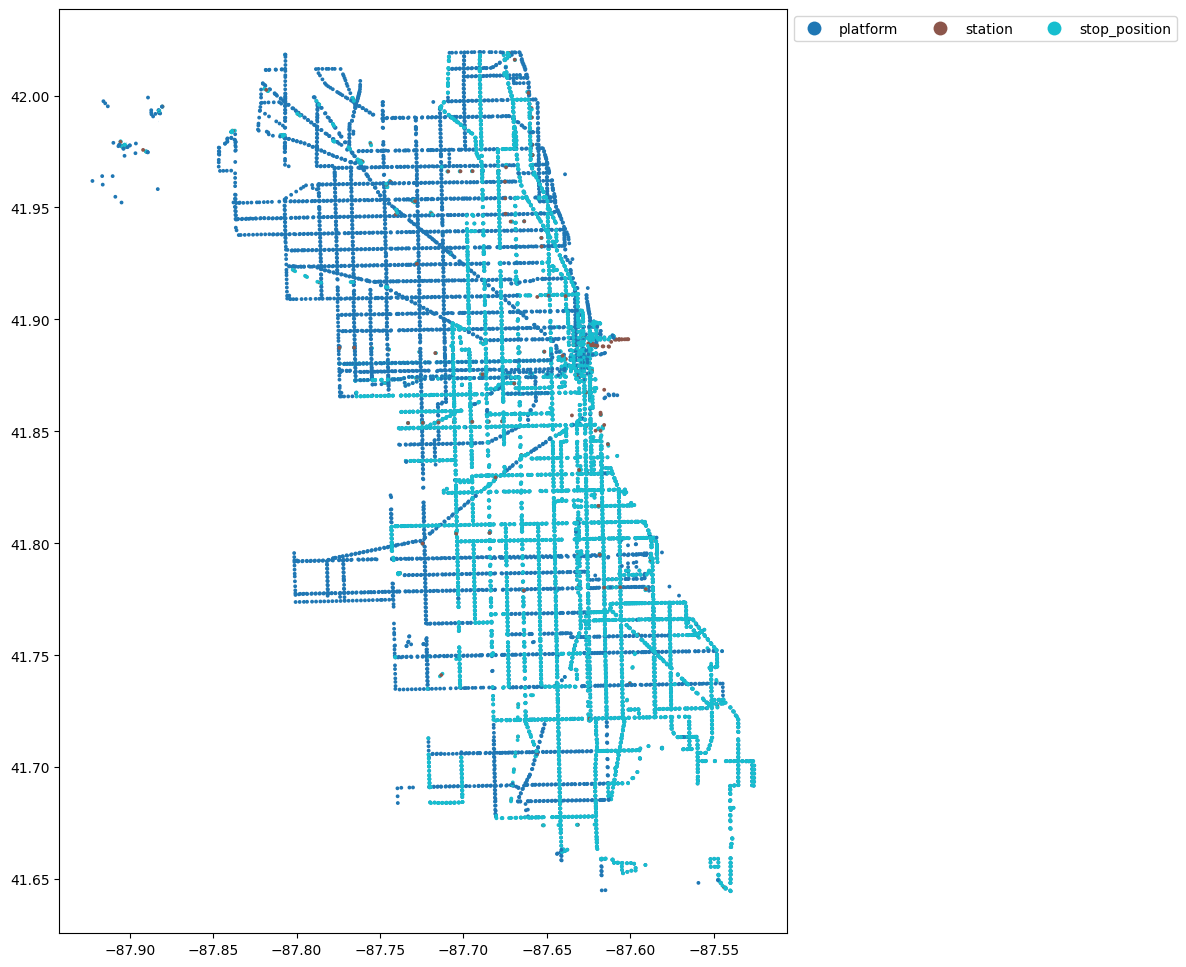

In [32]:
testDF2 = df[df["public_transport"].notna()]
ax = testDF2.plot(column='public_transport', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))